# Partial Delivery IV – Neural Network (NN)

In this notebook, we address the problem of predicting **crude protein** weight using the other variables in the dataset `sustavianfeed.xlsx`. This is achieved through **Neural Network** (NN) using symbolic regression to evolve a mathematical expression that approximates the target variable, while minimizing solution expression bloat.



### Imports

In [ ]:
# Standard Library
import os
import uuid
from uuid import uuid4
from datetime import datetime
from collections import defaultdict

# Data Handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mlxtend.plotting import plot_decision_regions

# Progress Bar
from tqdm import tqdm

# Scikit-learn
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Custom Modules
from nel_utils import json_parser, plotter, imputer, caller, selector

### Global settings

In [56]:
seed = 1
device = 'cpu'

## 2. Data Wrangling

We now ingest, and wrangle the data.

In [57]:
csv_file = '../data/sustavianfeed.xlsx' 
df = pd.read_excel(csv_file, index_col='WING TAG', na_values="/")
df.head()

,WEIGHT,HOT CARCASS WEIGHT,CARCASS WEIGHT WITH HEAD AND LEGS,COLD CARCASS WEIGHT,BREAST WEIGHT (2),THIGH WEIGHT (2),SPLEEN,LIVER,HEART,INTESTINE,EMPTY MUSCULAR STOMACH,GLANDULAR STOMACH,CRUDE PROTEIN,ETHER EXTRACT
WING TAG,,,,,,,,,,,,,,
G403,2223.3,1429.6,1725.6,1394.0,214.0,489.4,3.716,38.636,9.305,123.171,NaN,13.170,86.105469,0.38
G439,2201.9,1450.2,1769.8,1405.4,236.0,538.7,3.494,34.725,10.084,71.800,45.273,9.781,86.143472,1.66
G454,2159.9,1398.4,1724.9,1461.7,241.8,512.1,4.023,31.932,10.635,61.380,NaN,6.217,86.416898,0.98
G465,2198.7,1473.9,1800.4,1425.1,227.7,549.9,3.087,32.326,11.927,64.879,35.861,8.358,85.959935,1.10
G428,2003.2,1291.2,1581.6,1260.1,224.7,473.2,3.723,30.105,9.855,68.562,36.526,7.572,81.693637,6.34


In [58]:
# Deal with missing 
df = imputer.knn_impute(df, n_neighbors=5)

In [59]:
X = df.drop(columns='CRUDE PROTEIN')
y = df['CRUDE PROTEIN']

In [60]:
tf.config.set_visible_devices([], 'GPU')
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


### 2.1. NN definitions and compilation

In [70]:
# Validate input data
if X.isna().any().any() or y.isna().any():
    raise ValueError("Input data contains NaN values")
if not np.all(np.isfinite(X)) or not np.all(np.isfinite(y)):
    raise ValueError("Input data contains infinite values")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Define batch sizes
batch_size_GD = X.shape[0]  # Full batch for GD
batch_size_SGD = 1          # Single sample for SGD
batch_size_MiniSGD = 32     # Mini-batch for MiniSGD and others

# Neural network architecture
def create_model(optimizer='SGD', learning_rate=0.01, momentum=0.0):
    model = Sequential([
        Input(shape=(X.shape[1],)),
        Dense(3, activation='relu',
              kernel_initializer=tf.keras.initializers.GlorotUniform(),
              bias_initializer=tf.keras.initializers.Zeros()),
        Dense(4, activation='relu'),
        Dense(1, activation='linear')
    ])
    if optimizer in ['GD', 'SGD', 'MiniSGD']:
        opt = SGD(learning_rate=learning_rate, momentum=momentum)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse', metrics=[RootMeanSquaredError()])
    return model

# Custom Keras wrapper
class KerasRegressor(BaseEstimator):
    def __init__(self, optimizer='SGD', learning_rate=0.01, momentum=0.0, batch_size=32, epochs=500, run_id=None, log_history=False):
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.batch_size = batch_size
        self.epochs = epochs
        self.run_id = run_id or str(uuid.uuid4())
        self.log_history = log_history
        self.model = None
        self.history = None  # Store history for validation loss

    def fit(self, X, y):
        self.model = create_model(self.optimizer, self.learning_rate, self.momentum)
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)  # Monitor validation loss
        with tf.device('/cpu:0'):
            history = self.model.fit(
                X, y,
                epochs=self.epochs,
                batch_size=self.batch_size,
                callbacks=[early_stopping],
                validation_split=0.2,  # Use 20% of training data for validation
                verbose=0
            )
        self.history = history.history  # Save history
        if self.log_history:
            self._save_history_to_csv(history)
        return self

    def _save_history_to_csv(self, history):
        df_history = pd.DataFrame(history.history)
        timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
        filename = f"training_history_{self.optimizer}_{self.run_id}_{timestamp}.csv"
        df_history.to_csv(filename, index=False)

    def predict(self, X):
        y_pred = self.model.predict(X, verbose=0).flatten()
        if not np.all(np.isfinite(y_pred)):
            y_pred = np.nan_to_num(y_pred, nan=0.0, posinf=0.0, neginf=0.0)
        return y_pred

    def score(self, X, y):
        y_pred = self.predict(X)
        return -np.sqrt(mean_squared_error(y, y_pred))

# Nested CV setup
outer_splits = 3
inner_splits = 3
num_epochs = 15  

# Param grids
param_grid_sgd_base = {
    'learning_rate': [0.01, 0.05],
    'momentum': [0.0, 0.5, 0.9],
}

param_grid_others = {
    'learning_rate': [0.01, 0.05],
    'batch_size': [batch_size_MiniSGD]
}

results = {
    'GD': {'test_rmse': [], 'train_rmse': [], 'val_loss': []},
    'SGD': {'test_rmse': [], 'train_rmse': [], 'val_loss': []},
    'MiniSGD': {'test_rmse': [], 'train_rmse': [], 'val_loss': []},
    'RMSprop': {'test_rmse': [], 'train_rmse': [], 'val_loss': []},
    'Adam': {'test_rmse': [], 'train_rmse': [], 'val_loss': []}
}
best_params = {'GD': [], 'SGD': [], 'MiniSGD': [], 'RMSprop': [], 'Adam': []}

outer_kf = KFold(n_splits=outer_splits, shuffle=True, random_state=42)

for fold_idx, (train_idx, test_idx) in enumerate(outer_kf.split(X_scaled)):
    print(f"\nOuter Fold {fold_idx + 1}/{outer_splits}")
    X_outer_train, X_outer_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y_outer_train, y_outer_test = y.iloc[train_idx], y.iloc[test_idx]

    for opt in ['GD', 'SGD', 'MiniSGD', 'RMSprop', 'Adam']:
        print(f"  Training {opt} model...")
        run_id = f"{opt}_fold{fold_idx + 1}_{uuid4().hex[:6]}"

        # Build param grid
        if opt in ['GD', 'SGD', 'MiniSGD']:
            param_grid = {
                **param_grid_sgd_base,
                'batch_size': [batch_size_GD if opt == 'GD' else batch_size_SGD if opt == 'SGD' else batch_size_MiniSGD]
            }
        else:
            param_grid = param_grid_others

        # Grid search (log_history = False)
        model = KerasRegressor(optimizer=opt, epochs=num_epochs, run_id=run_id, log_history=False)
        grid = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=inner_splits,
            scoring='neg_root_mean_squared_error',
            n_jobs=1,
            verbose=0
        )
        grid.fit(X_outer_train, y_outer_train)
        best_params[opt].append(grid.best_params_)

        # Final model with log enabled
        best_model = KerasRegressor(
            optimizer=opt,
            learning_rate=grid.best_params_['learning_rate'],
            momentum=grid.best_params_.get('momentum', 0.0),
            batch_size=grid.best_params_['batch_size'],
            epochs=num_epochs,
            run_id=run_id,
            log_history=True
        )
        best_model.fit(X_outer_train, y_outer_train)
        
        # Calculate RMSE for test and training sets
        y_pred_test = best_model.predict(X_outer_test)
        y_pred_train = best_model.predict(X_outer_train)
        test_rmse = np.sqrt(mean_squared_error(y_outer_test, y_pred_test))
        train_rmse = np.sqrt(mean_squared_error(y_outer_train, y_pred_train))
        results[opt]['test_rmse'].append(test_rmse)
        results[opt]['train_rmse'].append(train_rmse)
        results[opt]['val_loss'].append(min(best_model.history.get('val_loss', [float('inf')])))  
        
        print(f"    {opt} Test RMSE: {test_rmse:.4f}, Train RMSE: {train_rmse:.4f}, "
              f"RMSE Diff (Train-Test): {(train_rmse - test_rmse):.4f}, "
              f"Min Val Loss: {min(best_model.history.get('val_loss', [float('inf')])):.4f}, "
              f"Best Params: {grid.best_params_}")

# Summarize results
print("\nNested CV Results Summary:")
for opt in results:
    mean_test_rmse = np.mean(results[opt]['test_rmse'])
    std_test_rmse = np.std(results[opt]['test_rmse'])
    mean_train_rmse = np.mean(results[opt]['train_rmse'])
    mean_val_loss = np.mean(results[opt]['val_loss'])
    mean_rmse_diff = mean_train_rmse - mean_test_rmse
    print(f"{opt}:")
    print(f"  Mean Test RMSE: {mean_test_rmse:.4f} (±{std_test_rmse:.4f})")
    print(f"  Mean Train RMSE: {mean_train_rmse:.4f}")
    print(f"  Mean RMSE Difference (Train - Test): {mean_rmse_diff:.4f}")
    print(f"  Mean Min Validation Loss: {mean_val_loss:.4f}")
    print(f"  Best Parameters per fold: {best_params[opt]}")
    if mean_rmse_diff < -0.05:  
        print(f"  Warning: Potential overfitting detected for {opt} (Train RMSE significantly lower than Test RMSE)")


Outer Fold 1/3
  Training GD model...
    GD Test RMSE: 30.6527, Train RMSE: 33.4317, RMSE Diff (Train-Test): 2.7790, Min Val Loss: 1140.2885, Best Params: {'batch_size': 96, 'learning_rate': 0.05, 'momentum': 0.9}
  Training SGD model...
    SGD Test RMSE: 1.8839, Train RMSE: 2.1344, RMSE Diff (Train-Test): 0.2506, Min Val Loss: 2.3222, Best Params: {'batch_size': 1, 'learning_rate': 0.05, 'momentum': 0.0}
  Training MiniSGD model...
    MiniSGD Test RMSE: 1.8112, Train RMSE: 2.1581, RMSE Diff (Train-Test): 0.3469, Min Val Loss: 3.9359, Best Params: {'batch_size': 32, 'learning_rate': 0.05, 'momentum': 0.5}
  Training RMSprop model...
    RMSprop Test RMSE: 39.6257, Train RMSE: 31.9446, RMSE Diff (Train-Test): -7.6810, Min Val Loss: 1480.9529, Best Params: {'batch_size': 32, 'learning_rate': 0.05}
  Training Adam model...
    Adam Test RMSE: 69.7640, Train RMSE: 66.4752, RMSE Diff (Train-Test): -3.2888, Min Val Loss: 1982.3881, Best Params: {'batch_size': 32, 'learning_rate': 0.05}



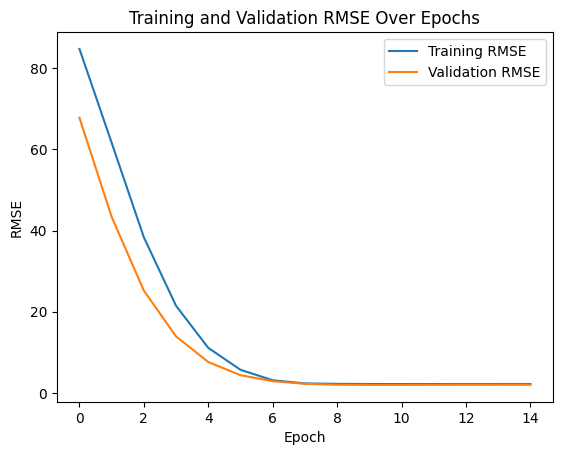

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# Fold 1
# Load the history data
df_history = pd.read_csv("log/PD4/training_history_MiniSGD_MiniSGD_fold1_3ff431_20250528-232841.csv")

# Plot two columns, e.g., 'root_mean_squared_error' and 'val_root_mean_squared_error'
plt.plot(df_history['root_mean_squared_error'], label='Training RMSE')
plt.plot(df_history['val_root_mean_squared_error'], label='Validation RMSE')

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training and Validation RMSE Over Epochs")
plt.legend()
plt.show()


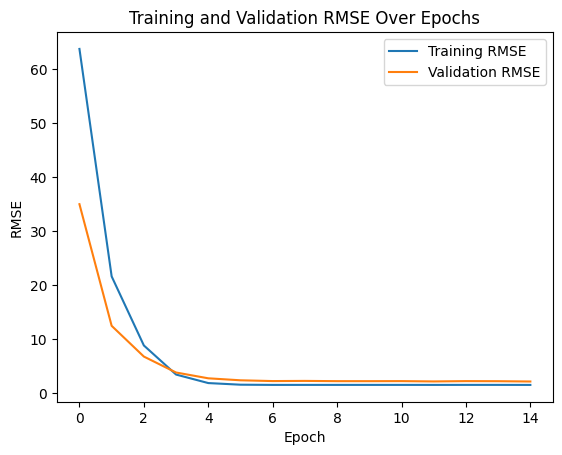

In [ ]:
# Fold 2
# Load the history data
df_history = pd.read_csv("log/PD4/training_history_SGD_SGD_fold2_79b1ef_20250528-233029.csv")

# Plot two columns, e.g., 'root_mean_squared_error' and 'val_root_mean_squared_error'
plt.plot(df_history['root_mean_squared_error'], label='Training RMSE')
plt.plot(df_history['val_root_mean_squared_error'], label='Validation RMSE')

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training and Validation RMSE Over Epochs")
plt.legend()
plt.show()


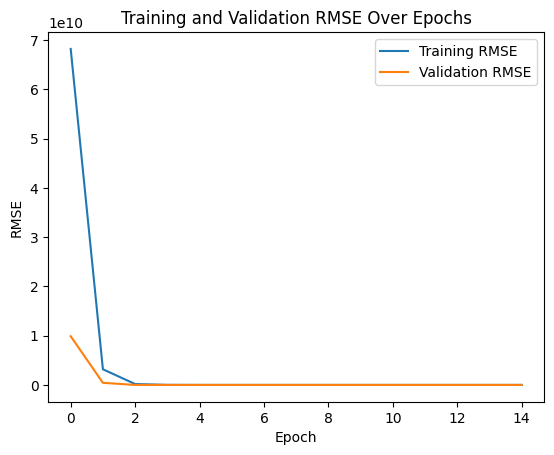

In [74]:
# Fold 3
# Load the history data
df_history = pd.read_csv("log/PD4/training_history_SGD_SGD_fold3_03553e_20250528-233303.csv")

# Plot two columns, e.g., 'root_mean_squared_error' and 'val_root_mean_squared_error'
plt.plot(df_history['root_mean_squared_error'], label='Training RMSE')
plt.plot(df_history['val_root_mean_squared_error'], label='Validation RMSE')

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training and Validation RMSE Over Epochs")
plt.legend()
plt.show()

The best optimizer on average was SGD. The neural network outperformed all previously tested algorithms, demonstrating superior predictive capability. After evaluating multiple runs, we selected a low number of epochs, as the model consistently converged between the 5th and 10th epochs.

However, overfitting was observed in certain folds during cross-validation, where the model achieved excellent performance on the training data but struggled to generalize effectively to unseen data. Interestingly, some optimizers exhibited a greater tendency to overfit, which may be attributed to their sensitivity to noise or their approach to navigating the loss landscape—resulting in memorization of the training samples rather than learning generalized patterns.
